In [7]:
import __main__
print(__main__.__package__)

None


In [8]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
import kagglehub

path = kagglehub.dataset_download("financekim/curated-cxr-report-generation-dataset")

print("Path to dataset files:", path)

100%|██████████| 7.98G/7.98G [00:59<00:00, 144MB/s] 

Extracting files...


Path to dataset files: /home/cc/.cache/kagglehub/datasets/financekim/curated-cxr-report-generation-dataset/versions/13


In [14]:
df_dir = "../data/13/Cleanses csv tfrecords/"
df_train_name = "df_train.csv"
df_val_name = "df_val.csv"

In [15]:
import pandas as pd

mimic_df_train = pd.read_csv(df_dir + df_train_name)
mimic_df_test = pd.read_csv(df_dir + df_val_name)

In [18]:
mimic_df_train.head()

,id,text,path
0,s50260386,A tip of a left Port-A-Cath lies in the low su...,../input/curated-cxr-report-generation-dataset...
1,s58019009,"AP chest compared to ___, 9:04 a.m.: In place ...",../input/curated-cxr-report-generation-dataset...
2,s54123565,"AP chest compared to ___, read in conjunction ...",../input/curated-cxr-report-generation-dataset...
3,s51811896,A tracheostomy cannula is located within the u...,../input/curated-cxr-report-generation-dataset...
4,s59641633,Bilateral previous mentioned reticular opaciti...,../input/curated-cxr-report-generation-dataset...


In [19]:
mimic_df_test.head()

,id,text,path
0,s55512076,Comparison is made to prior study performed a ...,../input/curated-cxr-report-generation-dataset...
1,s55786650,"As compared to the previous radiograph, there ...",../input/curated-cxr-report-generation-dataset...
2,s56188631,AP chest compared to ___ through ___. Elevatio...,../input/curated-cxr-report-generation-dataset...
3,s53690114,Compared to prior study there is no significan...,../input/curated-cxr-report-generation-dataset...
4,s52070116,In comparison to prior radiograph of 1 day ear...,../input/curated-cxr-report-generation-dataset...


In [16]:
print(f"Shape train data: {mimic_df_train.shape}")
print(f"Shape test data: {mimic_df_test.shape}")

Shape train data: (93347, 3)
Shape test data: (1885, 3)


In [17]:
train_img_dir = '../data/13/mimic_dset/re_512_3ch/Train'
test_img_dir = '../data/13/mimic_dset/re_512_3ch/Test'

In [20]:
# Prepare Dataset
mimic_df_train['path'] = mimic_df_train.apply(lambda x: f"{train_img_dir}/{x['id']}.jpg", axis=1)
mimic_df_test['path'] = mimic_df_test.apply(lambda x: f"{test_img_dir}/{x['id']}.jpg", axis=1)

In [22]:
def sampling(df, sample_size, seed=42):
  valid = pd.DataFrame()
  remaining_df = df.copy()

  while len(valid) < sample_size:
    n_needed = sample_size - len(valid)
    sample = remaining_df.sample(n=n_needed, random_state=seed)
    # Check if the file exists or not
    sample['exists'] = sample['path'].apply(os.path.exists)
    valid_samples = sample[sample['exists']]
    valid = pd.concat([valid, valid_samples], ignore_index=True)
    remaining_df = remaining_df.drop(index=sample.index)

    if remaining_df.empty and len(valid) < sample_size:
      break # no more data
  return valid.drop(columns=['exists']).reset_index(drop=True)

In [23]:
# Because this is just assignment, I will reduce the train and test to [1000, 100]
train_df = sampling(mimic_df_train, 3000)
test_df = sampling(mimic_df_test, 300)

In [24]:
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Train Data Shape: (3000, 3)
Test Data Shape: (300, 3)


Index Data: 0
Captions: Single upright AP image of the chest. Lungs well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is unremarkable. No free air is seen in the upper abdomen.


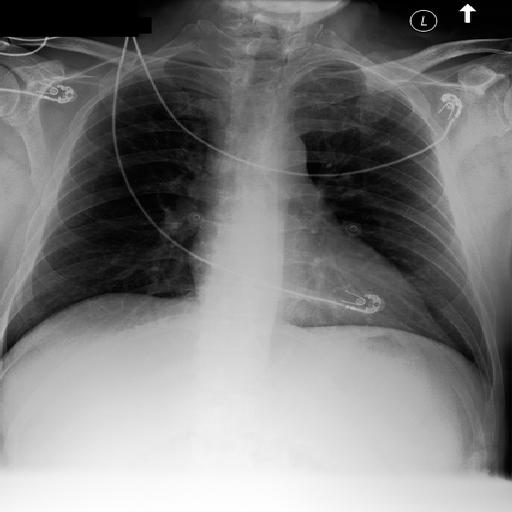

In [26]:
# Data Example
from PIL import Image

print("=" * 50)
print("Index Data: 0")
print(f"Captions: {train_df['text'][0]}")
print("=" * 50)
Image.open(train_df['path'][0])